In [25]:
import os
import pandas as pd
import numpy as np
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt

**Extend the naive solution**
* Use VGG16 pretrained on ImageNet
    * ImageNet dataset contains 1.4million labeled images and 1000 classess including different species of cats and dogs

#### Read data

The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [26]:
PATH = '/Users/fi000980702/Documents/Work/Chapter5/data/'
train_dir = os.path.join(PATH, 'training')
val_dir = os.path.join(PATH, 'validation')

In [27]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')

In [28]:
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(val_cats_dir))
num_dogs_val = len(os.listdir(val_dogs_dir))
total_train = num_cats_train + num_dogs_train
total_val = num_cats_val + num_dogs_val

In [29]:
print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 4000
total training dog images: 4000
total validation cat images: 1000
total validation dog images: 1000
--
Total training images: 8000
Total validation images: 2000


#### Pretrained VGG16 on ImageNet
* We omit the densely connected layer because the representations learned by the convolutional layer are likely to be more generic and therefore more reusable whereas the representations learned by the classifier will necessarily be spesific to the set of classes on which the model was trained. Therefore we set ```include_top=False```

In [30]:
image_height = 150
image_width = 150
channels = 3
batch_size = 16
epochs = 6

In [31]:
conv_base = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_height, image_width, channels),
    pooling='max')
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [32]:
# Set up augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest') 

# Validation data will not augmented
val_datagen = ImageDataGenerator(rescale=1./255) 

In [33]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(image_width, image_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir, 
    target_size=(image_width, image_height), 
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. 

Additionally, we will fine-tune the last 3 convolutional layers, which means that all layers up until **block4_pool** should be frozen, and the layers **block5_conv1, block5_conv2 and block5_conv3** should be trainable. We fine-fune only the last three layers because earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. Therefore, it is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem.

In [34]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [35]:
model = Sequential()
for layer in conv_base.layers:
    model.add(layer)
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

rmsprop = optimizers.RMSprop(lr=2e-5, decay=1e-5)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

Below we saa that the last three convolutional layers in addition to the dense layers are all trainable whereas the preceeding layers are frozen.

In [36]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13fcaf8d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13fcaff50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x13fcb3e90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13df7ced0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13d7c81d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x13fcdd750> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13fce6cd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13d7dfed0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13fd06910> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x13fd74790> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13fd7ccd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x13fd93b50> False
<tensorflow.pyth

In [37]:
start_time = time.time()     

lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=1, 
    verbose=1, 
    factor=0.2, 
    min_lr=1e-5)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=total_train//batch_size, 
    epochs=epochs,
    validation_data=val_generator, 
    validation_steps=total_val//batch_size,
    callbacks=[lr_plateau])

total_time = (time.time() - start_time)/60                                     
print('Execution time {:2f} minutes'.format(total_time))   

Epoch 1/6
500/500 [==============================] - 5465s 11s/step - loss: 0.4347 - acc: 0.7910 - val_loss: 0.2120 - val_acc: 0.9160
Epoch 2/6
500/500 [==============================] - 5073s 10s/step - loss: 0.2880 - acc: 0.8771 - val_loss: 0.2019 - val_acc: 0.9270
Epoch 3/6
499/500 [============================>.] - ETA: 8s - loss: 0.2390 - acc: 0.8999 
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-05.
500/500 [==============================] - 4784s 10s/step - loss: 0.2393 - acc: 0.8997 - val_loss: 0.2053 - val_acc: 0.9250
Epoch 4/6
500/500 [==============================] - 4791s 10s/step - loss: 0.2086 - acc: 0.9155 - val_loss: 0.2300 - val_acc: 0.9175
Epoch 5/6
500/500 [==============================] - 5206s 10s/step - loss: 0.1921 - acc: 0.9246 - val_loss: 0.1706 - val_acc: 0.9420
Epoch 6/6
500/500 [==============================] - 5362s 11s/step - loss: 0.1897 - acc: 0.9230 - val_loss: 0.1449 - val_acc: 0.9485
Execution time 511.362030 minutes


In [38]:
model.save('VGG16_binary_w_aug.h5')

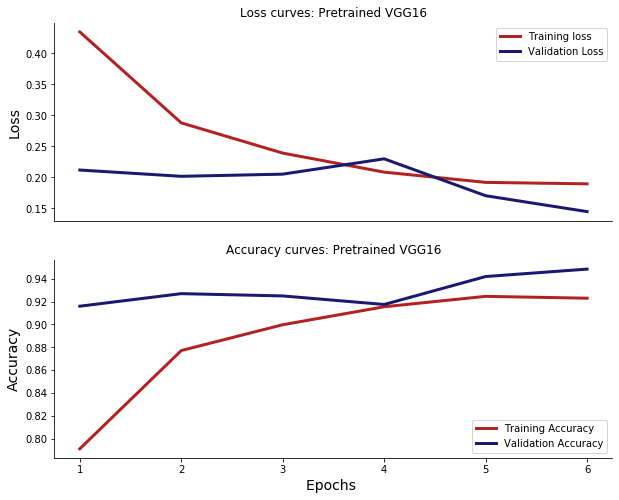

In [39]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,8))

history_dict = history.history
epochs = range(1, len(history_dict['acc'])+1)

ax0.plot(epochs, history_dict['loss'], 'firebrick', linewidth=3.0)
ax0.plot(epochs, history_dict['val_loss'], 'midnightblue', linewidth=3.0)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.tick_params(bottom=False)
ax0.set_xticklabels([])
ax0.set_title('Loss curves: Pretrained VGG16')
ax0.set_ylabel('Loss', fontsize=14)
ax0.legend(['Training loss', 'Validation Loss'], loc='best')

ax1.plot(epochs, history_dict['acc'], 'firebrick', linewidth=3.0)
ax1.plot(epochs, history_dict['val_acc'], 'midnightblue' ,linewidth=3.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Accuracy curves: Pretrained VGG16')
ax1.set_xlabel('Epochs ', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')